In [1]:
import numpy as np
import matplotlib.pyplot as plt

from QKDfunctions import *

from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, Aer
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.circuit import Parameter
from qiskit.extensions import IdGate
from qiskit.providers.aer.noise import NoiseModel, errors

from IPython.display import display, Math, Latex, clear_output

# MDI protocol
## Table of Contents:
* [Introduction & Theory](#intro)
* [Plain protocol](#protocol)
* [Working protocol with Eavesdropper](#eve)
* [Protocol on NV with Noise](#noise)


## Introduction & Theory <a class="anchor" id="intro"></a>

In the MDI protocol Alice and Bob both prepare a random state $\mid+\rangle,\mid-\rangle,\mid0\rangle,\mid1\rangle$. They both send their states to a third party, Charlie, who performs a Bell state measurement (BSM). Charlie then communicates the outcome of this BSM to Bob. Alice and Bob then compare bases used. If they used the same basis, the BSM will tell Bob if their bits were correlates or anticorrelated. Bob can then do a bit flip based on this to ensure Alice and Bob got the same bit.

The outcome of the BSM has slightly different meanings for the 0/1 and +/- basis. The meanings if the first bit is the one with the rotation gate and the control side of the cnot:
> 0/1 basis: 00; cor, 01; cor, 10; anti, 11; anti.

> +/- basis: 00; cor, 01; anti, 10; cor, 11; anti.

## Plain protocol <a class="anchor" id="protocol"></a>

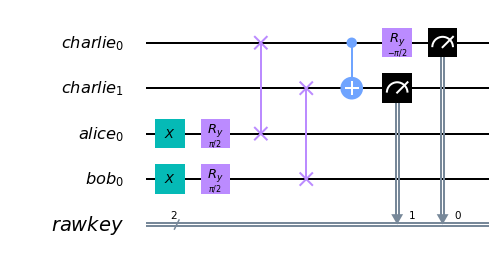

In [2]:
# Create the circuit
A = QuantumRegister(1, 'alice')
B = QuantumRegister(1, 'bob')
C = QuantumRegister(2, 'charlie')
rawkey = ClassicalRegister(2, 'raw key')

qc = QuantumCircuit(C, A, B, rawkey)

# Add the gates
qc.x(A[0])  # Optional
qc.x(B[0])  # Optional
qc.ry(np.pi/2, A[0])  # Optional
qc.ry(np.pi/2, B[0])  # Optional

qc.swap(C[0], A[0])
qc.swap(C[1], B[0])
qc.cx(C[0], C[1])
qc.ry(-np.pi/2, C[0])

qc.measure(C[0], rawkey[0])
qc.measure(C[1], rawkey[1])

cplot=qc.draw(output='mpl')
display(cplot)

## Working protocol with Eavesdropper <a class="anchor" id="eve"></a>

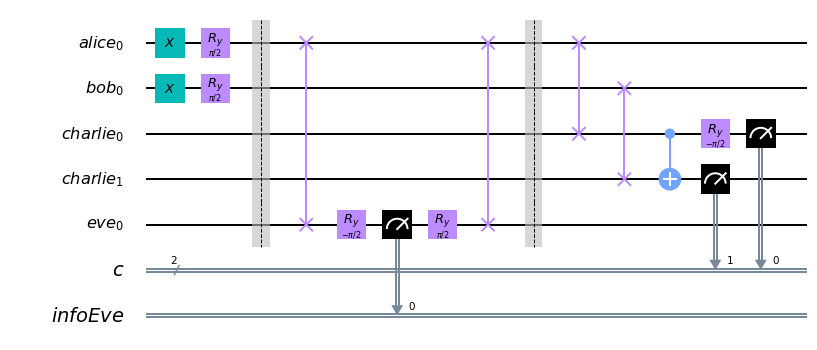

In [3]:
A = QuantumRegister(1, name = 'alice')
B = QuantumRegister(1, name = 'bob')
C = QuantumRegister(2, name = 'charlie')
E = QuantumRegister(1, 'eve')
cr = ClassicalRegister(2, name = 'c')
infoE = ClassicalRegister(1, "infoEve")

circuit = QuantumCircuit(A, B, C, E, cr, infoE)   
circuit.x(A)  
circuit.x(B)  
circuit.ry(np.pi/2,0)   
circuit.ry(np.pi/2,1)

# Eve drops (or doesnt)
circuit.barrier(A,B,C,E)
circuit.swap(A[0], E[0])
circuit.ry(-np.pi/2, E[0])
circuit.measure(E[0], infoE[0])
circuit.ry(np.pi/2, E[0])
circuit.swap(A[0], E[0])
circuit.barrier(A,B,C,E)

circuit.swap(A,C[0])
circuit.swap(B,C[1])

# Charlie performs BSM
circuit.cx(C[0],C[1])
circuit.ry(-np.pi/2, C[0])
circuit.measure(C[0],cr[0])
circuit.measure(C[1],cr[1])

cplot=circuit.draw(output='mpl')
display(cplot)

In [9]:
#Code with Eve
N = 10000
chanceE = 1   # Chance Eve drops (1 = 100%)
print_table = False

# Setup
basisA = np.random.randint(2, size=N)   # 0 means 0/1 basis, 1 means +/-
basisB = np.random.randint(2, size=N)
basisE = np.random.choice([0,1,2], p=[0.5*chanceE, 0.5*chanceE, 1-chanceE], size=N)

dataA = np.random.randint(2, size=N)
dataB = np.random.randint(2, size=N)
dataC = np.zeros((2,N), dtype=int)
dataE = np.zeros(N, dtype=int)

A = QuantumRegister(1, name = 'alice')
B = QuantumRegister(1, name = 'bob')
C = QuantumRegister(2, name = 'charlie')
E = QuantumRegister(1, 'eve')
cr = ClassicalRegister(2, name = 'c')
infoE = ClassicalRegister(1, "infoEve")

keyA = np.zeros(N, dtype=int)
keyB = np.zeros(N, dtype=int)
M = 0  # counter for key

if print_table:
    print('bit A B   | result E | result  C  | bitflip? ')
    print('--------------------------------------------------')

# Build and run the circuits
for i in range(N):
    circuit = QuantumCircuit(A, B, C, E, cr, infoE)
    if(dataA[i] == 1):    
        circuit.x(A)
    if(dataB[i] == 1):    
        circuit.x(B)
    if(basisA[i] == 1):    
        circuit.ry(np.pi/2,0)
    if(basisB[i] == 1):    
        circuit.ry(np.pi/2,1)
    
    # Eve drops (or doesnt)
    circuit.barrier(A,B,C,E)
    if basisE[i] == 0:
        circuit.swap(A[0], E[0])
        circuit.measure(E[0], infoE[0])
        circuit.swap(A[0], E[0])
    elif basisE[i] == 1:
        circuit.swap(A[0], E[0])
        circuit.ry(-np.pi/2, E[0])
        circuit.measure(E[0], infoE[0])
        circuit.ry(np.pi/2, E[0])
        circuit.swap(A[0], E[0])
    circuit.barrier(A,B,C,E)
    
    circuit.swap(A,C[0])
    circuit.swap(B,C[1])
    
    # Charlie performs BSM
    circuit.cx(C[0],C[1])
    circuit.ry(-np.pi/2, C[0])
    circuit.measure(C[0],cr[0])
    circuit.measure(C[1],cr[1])
    
    # Run circuit
    backend = BasicAer.get_backend('qasm_simulator')
    shots = 1
    results = execute(circuit, backend=backend, shots=shots).result()
    counts = results.get_counts()
    k = list(counts.keys())[0]
    k = ' '.join(k)
    data = np.fromstring(k,sep=' ', dtype=int)
    dataE[i] = data[0]
    dataC[:,i] = data[1:]
    
    # Do bit flip if necessary
    bitflip = ''
    if basisA[i] == basisB[i]: 
        keyA[M] = dataA[i]
        keyB[M] = dataB[i]
        bitflip = 'no '
        if basisA[i] == 0 and (list(dataC[:,i]) == [1,0] or list(dataC[:,i]) == [1,1]):
            bitflip = 'yes'
            keyB[M] = 1-keyB[M]
        if basisA[i] == 1 and (list(dataC[:,i]) == [0,1] or list(dataC[:,i]) == [1,1]):
            bitflip = 'yes'
            keyB[M] = 1-keyB[M]
        M += 1
            
    bitA = give_bit(basisA[i], dataA[i])
    bitB = give_bit(basisB[i], dataB[i])
    bitE = give_bit(basisE[i], dataE[i])

    if print_table: 
        print('   {0} {1}    |    {2}     |   {3}    |    {4}'.format(bitA, bitB, bitE, dataC[:,i], bitflip))
    else:
        # Show progress 
        print('Currently at: {0}/{1}  :  {2}%'.format(i+1, N, int(float((i+1))*100/N)))
        clear_output(wait=True)

keyA = keyA[0:M]
keyB = keyB[0:M]
QBER = np.sum(keyA != keyB)
print('QBER: {0}%'.format(int(QBER/M*100)))


QBER: 23%


## Protocol on NV with Noise <a class="anchor" id="noise"></a>

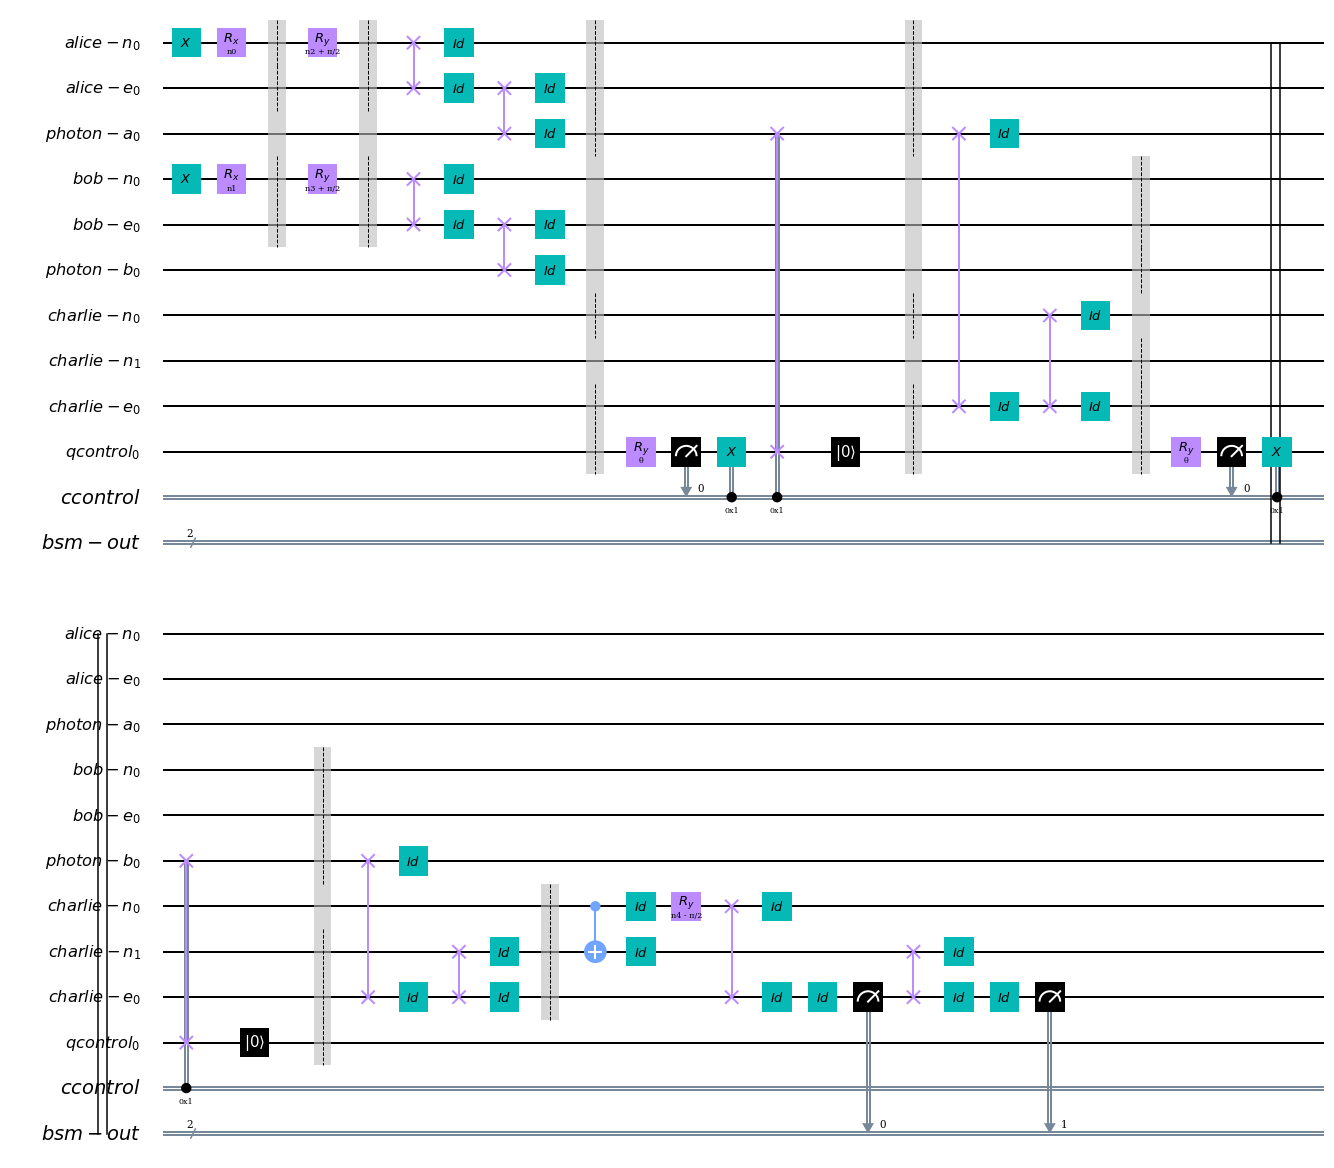

In [39]:
# Initialize variables 
N = 100             # number of shots per pick
number_picks = 15    # Number of picks per set of sigmas
length = 0.025        # Length of photon fiber
att_length = 0.542   # in km
Fg = 1-0.98          # Depolarizing parameter for two qubit gates in quantum memories
Fprep = 1-0.99       # Dephasing parameter for the memory-photon state preparation
Fm = 1-0.95          # Depolarizing parameter for the measurement of the electron spin
noise_n = 0.142       # The 1-sigmas that will be used on carbon gates
noise_e = 0.142       # The 1-sigmas that will be used on electron gates

# Create the circuit
An = QuantumRegister(1, 'alice-n')
Ae = QuantumRegister(1, 'alice-e')
Bn = QuantumRegister(1, 'bob-n')
Be = QuantumRegister(1, 'bob-e')
Cn = QuantumRegister(2, 'charlie-n')
Ce = QuantumRegister(1, 'charlie-e')
pa = QuantumRegister(1, 'photon-a')
pb = QuantumRegister(1, 'photon-b')
control = QuantumRegister(1,'qcontrol')
init = ClassicalRegister(1,'ccontrol')
BSM_out = ClassicalRegister(2, 'bsm-out')

qc = QuantumCircuit(An, Ae, pa, Bn, Be, pb, Cn, Ce, control, init, BSM_out)

# Define parameters    !you need one for EACH gate!
pi_par = Parameter('π')     # Parameter to show pi nicely
noise_n0 = Parameter('n0')  # Parameter to control noise on carbon gates
noise_n1 = Parameter('n1')  # 
noise_n2 = Parameter('n2')  # 
noise_n3 = Parameter('n3')  # 
noise_n4 = Parameter('n4')  # 
noise_e0 = Parameter('e')   # Parameter to control noise on electron gates
theta_par = Parameter('θ')  # Parameter to control relaxation noise of photon

# Alice and Bob prepare their qubits    (they choose |-> and |->)
noisy_x(qc, An[0], noise=noise_n0)
noisy_x(qc, Bn[0], noise=noise_n1)
qc.barrier(An, Ae, Bn, Be)
noisy_ry(pi_par/2, qc, An[0], noise=noise_n2)
noisy_ry(pi_par/2, qc, Bn[0], noise=noise_n3)
qc.barrier(An, Ae, Bn, Be)
# Alice and Bob send their qubits to Charlie, who stores them
send_photon_swap(qc, An[0], Ae, Cn[0], Ce, pa, control, init, theta_par)
noisy_swap(qc, Cn[0], Ce, 'Cswap')
send_photon_swap(qc, Bn[0], Be, Cn[1], Ce, pb, control, init, theta_par)
noisy_swap(qc, Cn[1], Ce, 'Cswap')
# Charlie performs BSM (noiseless at the moment)
qc.barrier(Cn,Ce)
noisy_cnot(qc, Cn[0], Cn[1], 'Cswap')
noisy_ry(pi_par/-2, qc, Cn[0], noise=noise_n4)
noisy_swap(qc, Cn[0], Ce, 'Cswap')
noisy_measure(qc, Ce, BSM_out[0])
noisy_swap(qc, Cn[1], Ce, 'Cswap')
noisy_measure(qc, Ce, BSM_out[1])

# DONT Loop through the parameters (YET)
noise_depo = Fg
noise_deph = Fprep
noise_meas = Fm
theta_val = 2*np.arccos(np.exp(-length/(2*att_length)))

backend = Aer.get_backend('qasm_simulator')

qber = np.zeros((20,20))
noise_meass = np.linspace(0,0.2, 20)
lengths = np.linspace(0,0.1, 20)
for i, noise_meas in enumerate(noise_meass):
    for j, length in enumerate(lengths):
        theta_val = 2*np.arccos(np.exp(-length/(2*att_length)))
        qber_pick = np.zeros(number_picks)
        for randpick in range(number_picks):
            # Choose a random noise for the carbon and electron gates
            n0 = np.random.normal(scale=noise_n)
            n1 = np.random.normal(scale=noise_n)
            n2 = np.random.normal(scale=noise_n)
            n3 = np.random.normal(scale=noise_n)
            n4 = np.random.normal(scale=noise_n)
            e0 = np.random.normal(scale=noise_e)

            # Build the noise model
            noisemodel = NoiseModel()
            depo = errors.depolarizing_error(noise_depo, 1)
            deph = errors.phase_damping_error(noise_deph, 1)
            depo_meas = errors.depolarizing_error(noise_meas, 1)
            noisemodel.add_all_qubit_quantum_error(depo,'Cswap')
            noisemodel.add_all_qubit_quantum_error(deph,'eswap')
            noisemodel.add_all_qubit_quantum_error(depo_meas,'meas')

            circuit = qc.bind_parameters({pi_par: np.pi, noise_n0: n0, noise_n1: n1, noise_n2: n2, noise_n3: n3, noise_n4: n4, theta_par: theta_val})

            # Execute the circuit and save the qber
            job = execute(circuit, backend=backend, shots=N, noise_model=noisemodel)
            result = job.result()
            counts = result.get_counts()

            try:
                qber_pick[randpick] += counts['01 0']/N
            except: pass
            try:
                qber_pick[randpick] += counts['11 0']/N
            except: pass
            try:
                qber_pick[randpick] += counts['01 1']/N
            except: pass
            try:
                qber_pick[randpick] += counts['11 1']/N
            except: pass
        qber[i,j] = np.mean(qber_pick)

    # Show progress 
    print('Currently at: {0}/{1}'.format(i, 20))
    clear_output(wait=True)
        
# Draw the circuit
display(qc.draw(output='mpl'))

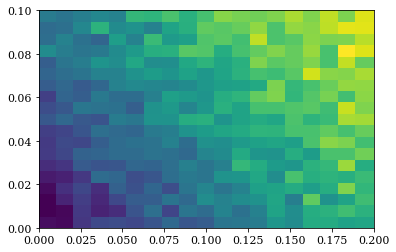

In [40]:
plt.pcolormesh(noise_meass, lengths, qber)

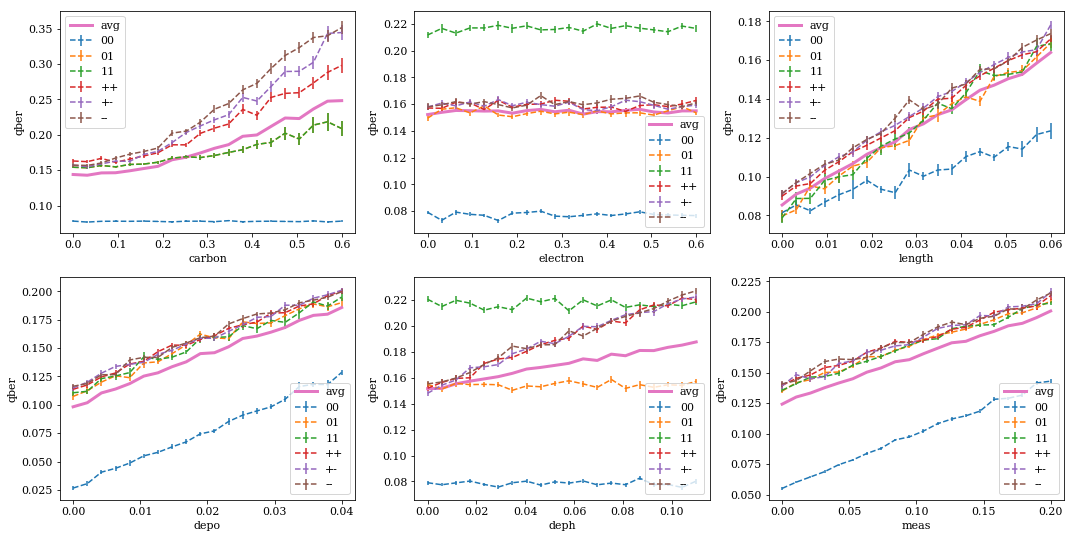

In [7]:
noises = ['carbon', 'electron', 'length', 'depo', 'deph', 'meas']
states = ['00', '01', '11', '++', '+-', '--']
noiselist = [0]*6
noiselist_std = [0]*6

for i, noise in enumerate(noises):
    noiselist[i] = np.loadtxt('data/mdi_'+noise)
    noiselist_std[i] = np.loadtxt('data/mdi_'+noise+'_std')

plot_noises(noiselist, noiselist_std, states, noises)